# Melanoma Classification : Exploratory Data Analysis

In [ ]:
# Importing all necessary library
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objects as go
import cv2
import gc

import random
from skimage import io

from tqdm import tqdm_notebook as tqdm
%matplotlib inline

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Exploratory Data Analysis

When we’re getting started with a machine learning (ML) project, one critical principle to keep in mind is that data is everything. It is often said that if ML is the rocket engine, then the fuel is the (high-quality) data fed to ML algorithms. However, deriving truth and insight from a pile of data can be a complicated and error-prone job. To have a solid start for our ML project, it always helps to analyze the data up front.

During EDA, it’s important that we get a deep understanding of:

* The properties of the data, such as schema and statistical properties;
* The quality of the data, like missing values and inconsistent data types;
* The predictive power of the data, such as correlation of features against target.

In [ ]:
# Creating test and train dataframe from the CSV file
train = pd.DataFrame(pd.read_csv("/content/drive/MyDrive/DJANGO/alalade/siim-isic-melanoma-classification/train.csv"))
test = pd.DataFrame(pd.read_csv("/content/drive/MyDrive/DJANGO/alalade/siim-isic-melanoma-classification/test.csv"))

In [ ]:
# Checking the data shape
train.shape, test.shape

((33126, 8), (10982, 5))

So, there are around 33k training images and about 10k testing images

In [ ]:
train.rename(columns={'benign_malignant': 'benign_melanoma'}, inplace=True)
train.loc[train['benign_melanoma'] == 'malignant', 'benign_melanoma'] = 'melanoma'

In [ ]:
# Viewing the top 5 rows
train.head()

image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_2637011  IP_7279968    male        45.0                     head/neck   
1  ISIC_0015719  IP_3075186  female        45.0               upper extremity   
2  ISIC_0052212  IP_2842074  female        50.0               lower extremity   
3  ISIC_0068279  IP_6890425  female        45.0                     head/neck   
4  ISIC_0074268  IP_8723313  female        55.0               upper extremity   

  diagnosis benign_melanoma  target  
0   unknown          benign       0  
1   unknown          benign       0  
2     nevus          benign       0  
3   unknown          benign       0  
4   unknown          benign       0

In [ ]:
test.head()

image_name  patient_id     sex  age_approx anatom_site_general_challenge
0  ISIC_0052060  IP_3579794    male        70.0                           NaN
1  ISIC_0052349  IP_7782715    male        40.0               lower extremity
2  ISIC_0058510  IP_7960270  female        55.0                         torso
3  ISIC_0073313  IP_6375035  female        50.0                         torso
4  ISIC_0073502  IP_0589375  female        45.0               lower extremity

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  32599 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_melanoma                33126 non-null  object 
 7   target                         33126 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 2.0+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10982 entries, 0 to 10981
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     10982 non-null  object 
 1   patient_id                     10982 non-null  object 
 2   sex                            10982 non-null  object 
 3   age_approx                     10982 non-null  float64
 4   anatom_site_general_challenge  10631 non-null  object 
dtypes: float64(1), object(4)
memory usage: 429.1+ KB


## Inference :

* Training set : Sex, age and anatomy_site have missing values.
* Test set : Anatomy_site have missing values.

We will take care of these further down in the notebook.

In [ ]:
len(train["patient_id"].unique()), len(test["patient_id"].unique())

(2056, 690)

## Inference :

This means that out of 33,126 registered entries in the training set, only 2,056 are unique implying that some patients are diagnosed with multiple marks.

Same goes for the test set where we have only 690 unique values out of collection of 10,982.

In [ ]:
def get_image_names(dataframe):
    '''This function get the image names from the dataframe provided(train/test).
    Add .jpg extension to them.
    params: dataframe
    '''
    image_names = dataframe["image_name"].values
    image_names = image_names + ".jpg"
    return image_names

In [ ]:
def get_info(image_names):
    '''This function convert the image_names list into numpy array.
    Prints mandatory information about this numpy array such as its length, type and shape.
    params: image_names
    '''
    image_names = np.array(image_names)

    print("Length = ", len(image_names))
    print("Type = ", type(image_names))
    print("Shape = ", image_names.shape)

    return image_names

Here, we will design our custom dataframe we have been bragging about since the inception of this notebook.
* Then we will take each image name one by one from the aforementioned numpy array, load that particular image and compute the necessary statistical information.
* All this will be appended in the custom dataframe.
* In the end, `this dataframe is returned and saved as .csv file, so that we can directly import it as an external dataset`.

In [ ]:
def extract_information(image_names, directory):
    ''''Here, we will design our custom dataframe we have been bragging about since the inception of this notebook.

    Then we will take each image name one by one from the aforementioned numpy array, load that particular image and compute the necessary statistical information.
    All this will be appended in the custom dataframe.
    In the end, this dataframe is returned and saved as .csv file, so that we can directly import it as an external dataset.
    '''
    image_statistics = pd.DataFrame(index = np.arange(len(image_names)),
                                    columns = ["image_name", "path", "rows", "columns", "channels",
                                              "image_mean", "image_standard_deviation", "image_skewness",
                                              "mean_red_value", "mean_green_value", "mean_blue_value"])
    i = 0
    for name in tqdm(image_names):
        path = os.path.join(directory, name)
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        image_statistics.iloc[i]["image_name"] = name
        image_statistics.iloc[i]["path"] = path
        image_statistics.iloc[i]["rows"] = image.shape[0]
        image_statistics.iloc[i]["columns"] = image.shape[1]
        image_statistics.iloc[i]["channels"] = image.shape[2]
        image_statistics.iloc[i]["image_mean"] = np.mean(image.flatten())
        image_statistics.iloc[i]["image_standard_deviation"] = np.std(image.flatten())
        image_statistics.iloc[i]["image_skewness"] = skew(image.flatten())
        image_statistics.iloc[i]["mean_red_value"] = np.mean(image[:,:,0])
        image_statistics.iloc[i]["mean_green_value"] = np.mean(image[:,:,1])
        image_statistics.iloc[i]["mean_blue_value"] = np.mean(image[:,:,2])

        i = i + 1
        del image

    return image_statistics

In [ ]:
stat_train_dir = "/content/drive/MyDrive/DJANGO/alalade/siim-isic-melanoma-classification/benign"

In [ ]:
image_names = get_image_names(train)
image_names = get_info(image_names)

Length =  33126
Type =  <class 'numpy.ndarray'>
Shape =  (33126,)


Uncomment these!! I have saved several csv files, each having information on about 5000 images.

In [ ]:
# image_statistics = extract_information(image_names[0:5000], stat_train_dir) # repeat this for image_names[5000:10k], image_names[10k-15k]...so on till 33126
# image_statistics.to_csv("melanoma_image_statistics_compiled_01", index = False)# save each one. I have computed it all beforehand, so wrote only one for instance.

# Distribution Observation

In [ ]:
print(train["target"].value_counts())

target
0    32542
1      584
Name: count, dtype: int64


## Melanoma VS Benign cases - OVERALL

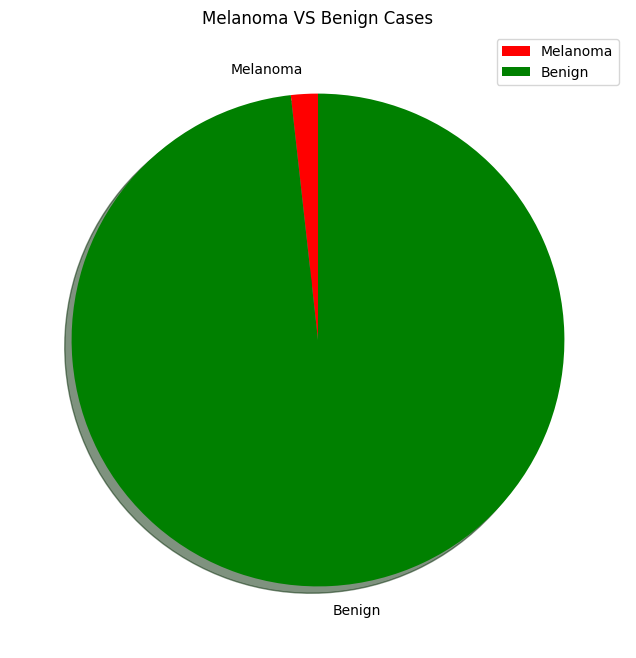

In [ ]:
# Calculate the number of melanoma cases
melanoma = len(train[train["target"] == 1])

# Calculate the number of benign cases
benign = len(train[train["target"] == 0])

# Define labels for the pie chart
labels = ["Melanoma", "Benign"]

# Define sizes for the pie chart corresponding to melanoma and benign cases
size = [melanoma, benign]

# Set the figure size for the plot
plt.figure(figsize = (8, 8))

# Create a pie chart with the given sizes and labels
# Shadow effect added for better visualization
# startangle sets the starting angle of the pie chart
# Colors are set to red for melanoma and green for benign
plt.pie(size, labels = labels, shadow = True, startangle = 90, colors = ["r", "g"])

# Set the title of the pie chart
plt.title("Melanoma VS Benign Cases")

# Display the legend on the plot
plt.legend()


Highly imbalanced dataset!!

## Male VS Female Count

Number of males in training set =  17080
Number of females in training set=  15981
Number of males in testing set =  6255
Number of females in testing set=  4727


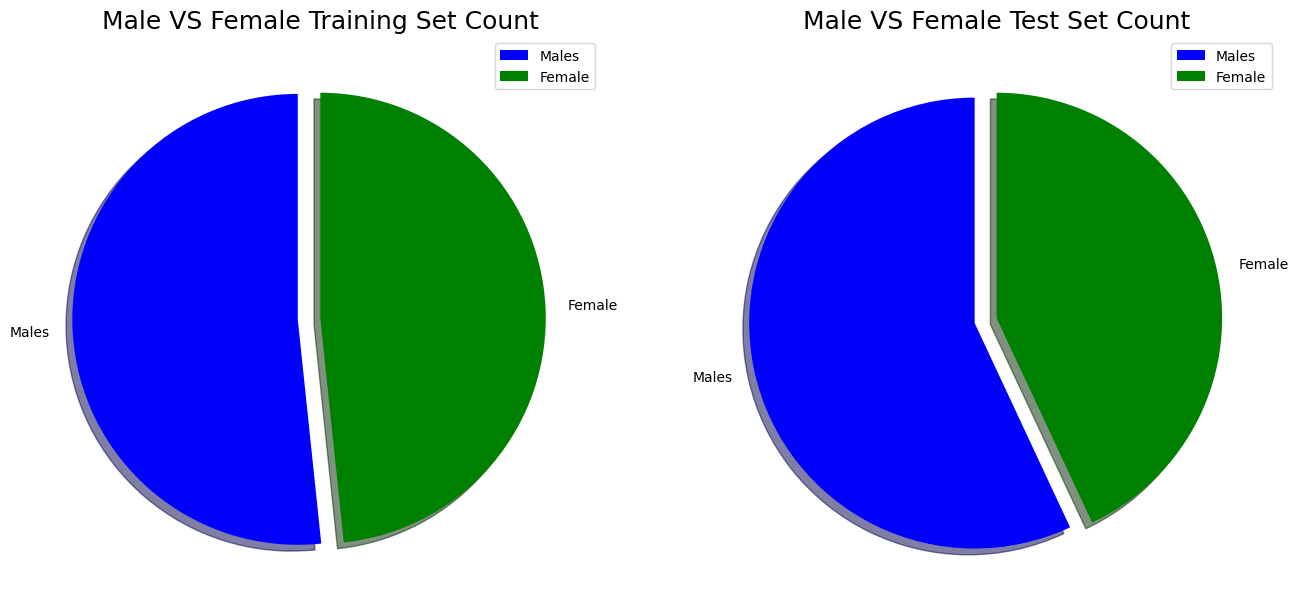

In [ ]:
train_males = len(train[train["sex"] == "male"])
train_females  = len(train[train["sex"] == "female"])

test_males = len(test[test["sex"] == "male"])
test_females  = len(test[test["sex"] == "female"])

labels = ["Males", "Female"]

size = [train_males, train_females]
explode = [0.1, 0.0]

# Visualizing the male vs female in the dataset
plt.figure(figsize = (16, 16))
plt.subplot(1,2,1)
plt.pie(size, labels = labels, explode = explode, shadow = True, startangle = 90, colors = ["b", "g"])
plt.title("Male VS Female Training Set Count", fontsize = 18)
plt.legend()

print("Number of males in training set = ", train_males)
print("Number of females in training set= ", train_females)

size = [test_males, test_females]

plt.subplot(1,2,2)
plt.pie(size, labels = labels, explode = explode, shadow = True, startangle = 90, colors = ["b", "g"])
plt.title("Male VS Female Test Set Count", fontsize = 18)
plt.legend()

print("Number of males in testing set = ", test_males)
print("Number of females in testing set= ", test_females)

## Melanoma male cases VS female cases

Melanoma Male Cases =  364
Melanoma Female Cases =  220


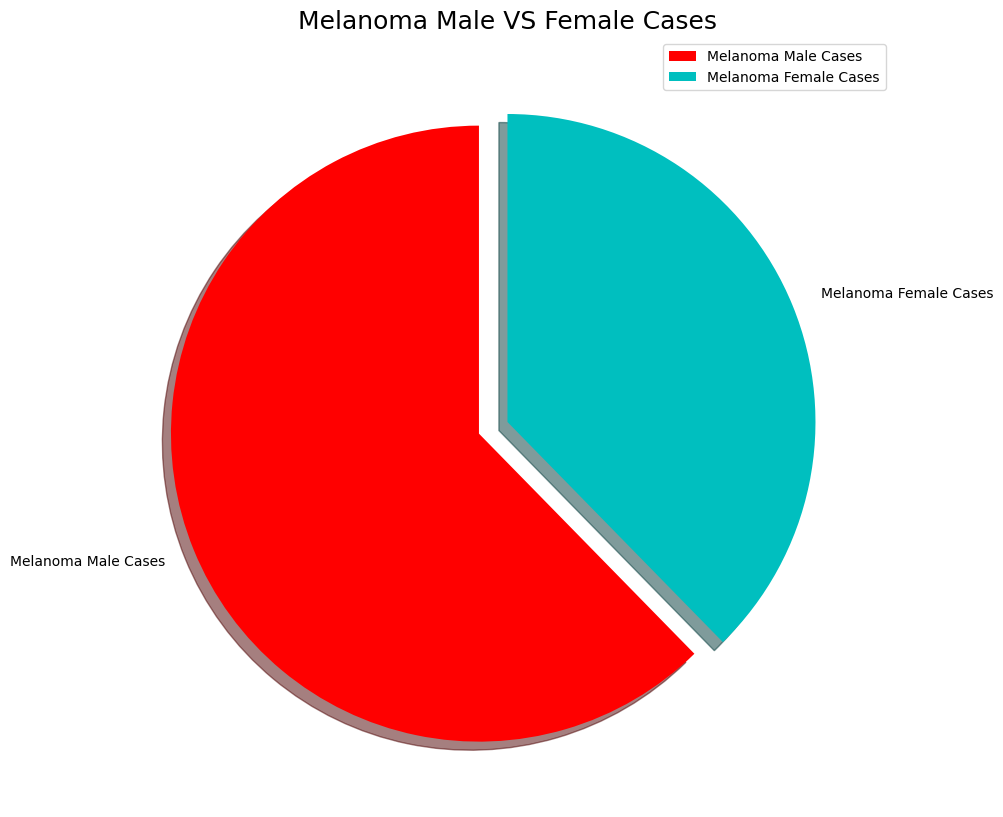

In [ ]:
# Melanoma count in the data
train_malignant  = train[train["target"] == 1]
train_malignant_males = len(train_malignant[train_malignant["sex"] == "male"])
train_malignant_females  = len(train_malignant[train_malignant["sex"] == "female"])

labels = ["Melanoma Male Cases", "Melanoma Female Cases"]
size = [train_malignant_males, train_malignant_females]
explode = [0.1, 0.0]

plt.figure(figsize = (10, 10))
plt.pie(size, labels = labels, explode = explode, shadow = True, startangle = 90, colors = ["r", "c"])
plt.title("Melanoma Male VS Female Cases", fontsize = 18)
plt.legend()
print("Melanoma Male Cases = ", train_malignant_males)
print("Melanoma Female Cases = ", train_malignant_females)

## Benign male cases vs female cases

Benign Male Cases =  16716
Benign Female Cases =  15761


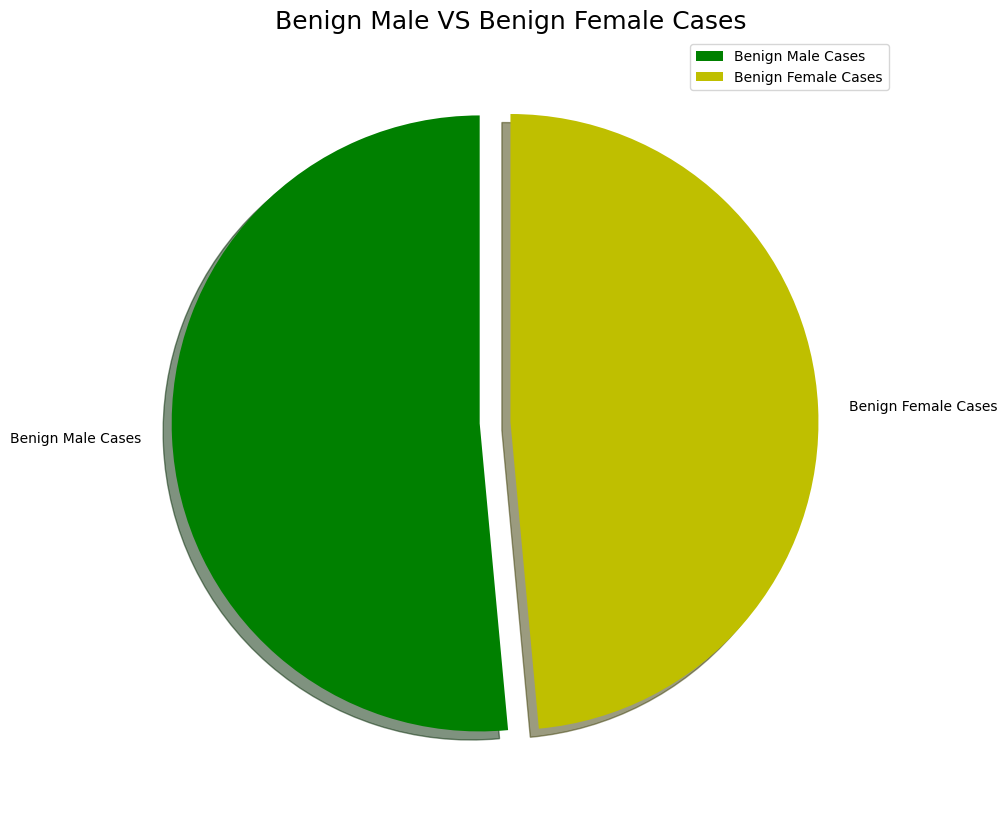

In [ ]:
# Visualizing the data
train_benign  = train[train["target"] == 0]

train_benign_males = len(train_benign[train_benign["sex"] == "male"])
train_benign_females  = len(train_benign[train_benign["sex"] == "female"])

labels = ["Benign Male Cases", "Benign Female Cases"]
size = [train_benign_males, train_benign_females]
explode = [0.1, 0.0]

plt.figure(figsize = (10, 10))
plt.pie(size, labels = labels, explode = explode, shadow = True, startangle = 90, colors = ["g", "y"])
plt.title("Benign Male VS Benign Female Cases", fontsize = 18)
plt.legend()
print("Benign Male Cases = ", train_benign_males)
print("Benign Female Cases = ", train_benign_females)

## Analysis of Cancer VS Sex

In [ ]:
cancer_versus_sex = train.groupby(["benign_melanoma", "sex"]).size()
print(cancer_versus_sex)
print(type(cancer_versus_sex))

benign_melanoma  sex   
benign           female    15761
                 male      16716
melanoma         female      220
                 male        364
dtype: int64
<class 'pandas.core.series.Series'>


In [ ]:
cancer_versus_sex = cancer_versus_sex.unstack(level = 1) / len(train) * 100
print(cancer_versus_sex)
print(type(cancer_versus_sex))

sex                 female       male
benign_melanoma                      
benign           47.578941  50.461873
melanoma          0.664131   1.098835
<class 'pandas.core.frame.DataFrame'>


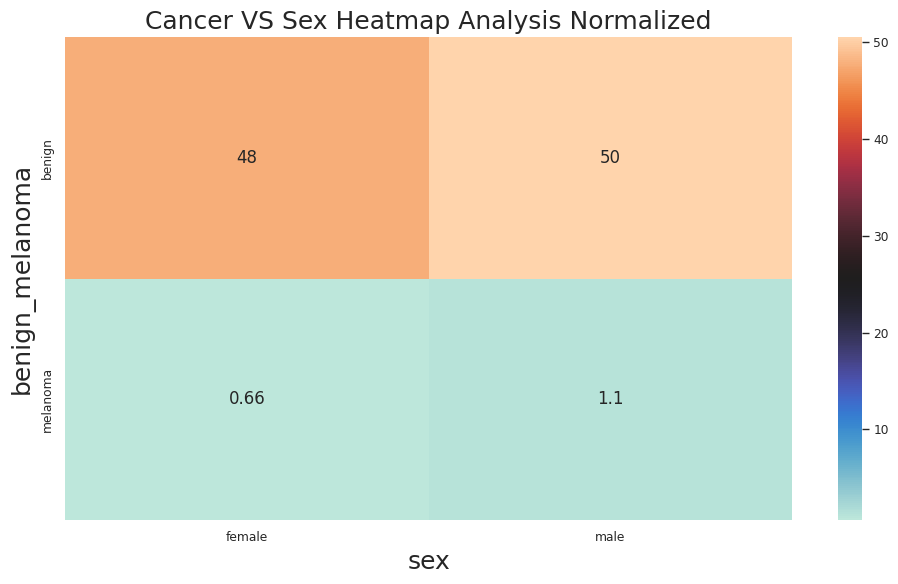

In [ ]:
sns.set(style='whitegrid')
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":20,"axes.labelsize":18})

plt.figure(figsize = (10, 6))
sns.heatmap(cancer_versus_sex, annot=True, cmap="icefire", cbar=True)
plt.title("Cancer VS Sex Heatmap Analysis Normalized", fontsize = 18)
plt.tight_layout()

## Analysis of Age VS Cancer :

<ipython-input-41-026e5d20118b>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=train["benign_melanoma"], y=train["age_approx"], palette="icefire")


<Figure size 1000x600 with 0 Axes>

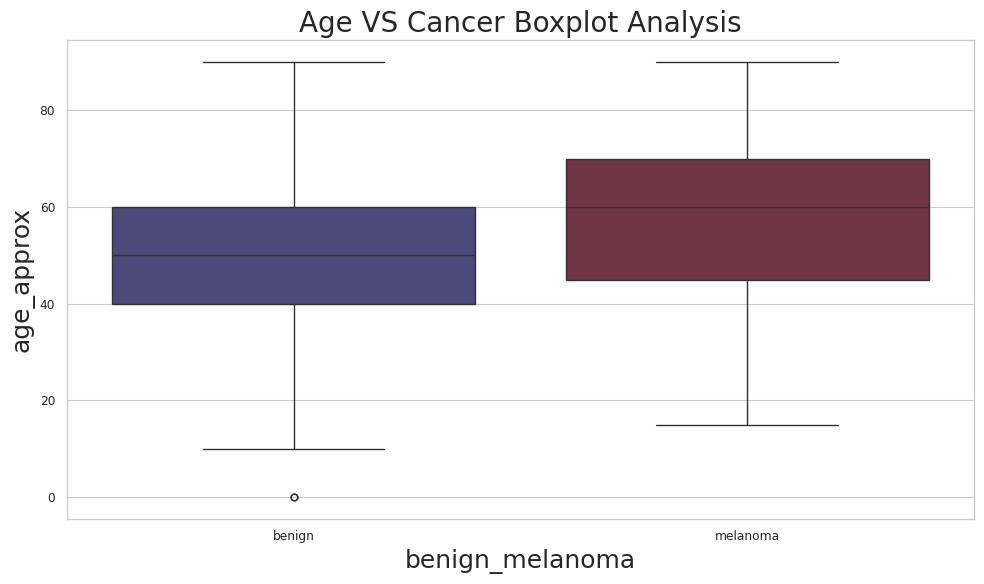

In [ ]:
sns.set(style='whitegrid')
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":20,"axes.labelsize":18})

plt.figure(figsize = (10, 6))
# sns.boxplot(train["benign_melanoma"], train["age_approx"], palette="icefire")
# plt.title("Age VS Cancer Boxplot Analysis")
# plt.tight_layout()

# Create the figure for the boxplot
plt.figure(figsize=(10, 6))

# Check if 'benign_melanoma' and 'age_approx' columns exist in the DataFrame
if 'benign_melanoma' in train.columns and 'age_approx' in train.columns:
    # Plot the boxplot
    sns.boxplot(x=train["benign_melanoma"], y=train["age_approx"], palette="icefire")
    plt.title("Age VS Cancer Boxplot Analysis")
    plt.tight_layout()
else:
    print("The required columns do not exist in the DataFrame.")

## Inference :

* The malignant cases belong to relatively higher age group.
* Age **might prove to be** a contributing factor in deciding whether the case is malignant or benign.
* From sex analysis we can hypothesize that sex **might be** a deciding factor as well.

In [ ]:
print("################### Training set info ###################")
print(train["anatom_site_general_challenge"].unique())
print(train["anatom_site_general_challenge"].value_counts())

print("\n\n")

print("################### Test set info ###################")
print(test["anatom_site_general_challenge"].unique())
print(test["anatom_site_general_challenge"].value_counts())

################### Training set info ###################
['head/neck' 'upper extremity' 'lower extremity' 'torso' nan 'palms/soles'
 'oral/genital']
anatom_site_general_challenge
torso              16845
lower extremity     8417
upper extremity     4983
head/neck           1855
palms/soles          375
oral/genital         124
Name: count, dtype: int64



################### Test set info ###################
[nan 'lower extremity' 'torso' 'upper extremity' 'head/neck' 'palms/soles'
 'oral/genital']
anatom_site_general_challenge
torso              5847
lower extremity    2501
upper extremity    1573
head/neck           576
palms/soles         108
oral/genital         26
Name: count, dtype: int64


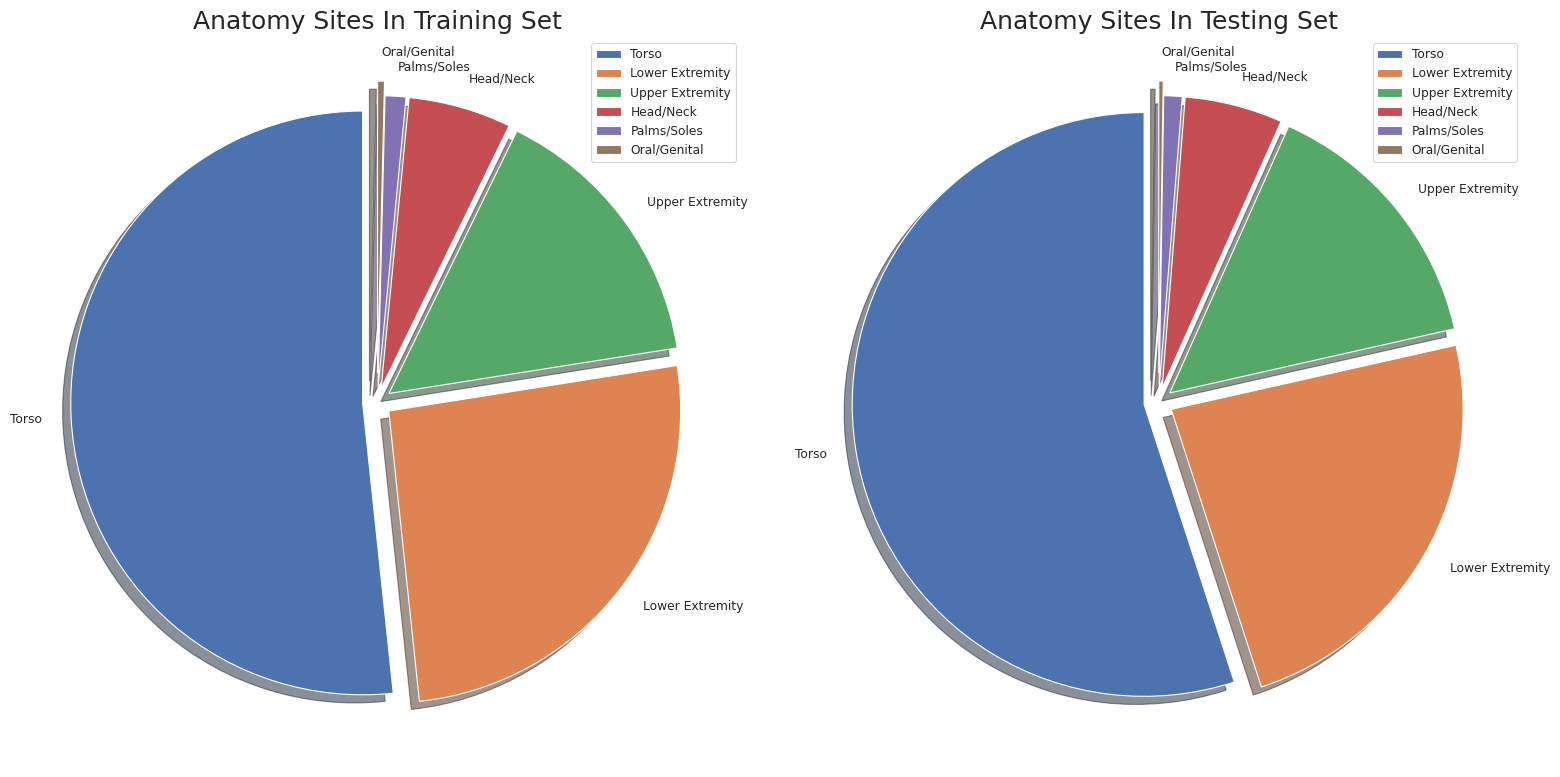

In [ ]:
# train
train_torso = len(train[train["anatom_site_general_challenge"] == "torso"])
train_lower_extremity = len(train[train["anatom_site_general_challenge"] == "lower extremity"])
train_upper_extremity = len(train[train["anatom_site_general_challenge"] == "upper extremity"])
train_head_neck = len(train[train["anatom_site_general_challenge"] == "head/neck"])
train_palms_soles = len(train[train["anatom_site_general_challenge"] == "palms/soles"])
train_oral_genital = len(train[train["anatom_site_general_challenge"] == "oral/genital"])

# test
test_torso = len(test[test["anatom_site_general_challenge"] == "torso"])
test_lower_extremity = len(test[test["anatom_site_general_challenge"] == "lower extremity"])
test_upper_extremity = len(test[test["anatom_site_general_challenge"] == "upper extremity"])
test_head_neck = len(test[test["anatom_site_general_challenge"] == "head/neck"])
test_palms_soles = len(test[test["anatom_site_general_challenge"] == "palms/soles"])
test_oral_genital = len(test[test["anatom_site_general_challenge"] == "oral/genital"])

################# DISPLAY #################

labels = ["Torso", "Lower Extremity", "Upper Extremity", "Head/Neck", "Palms/Soles", "Oral/Genital"]

plt.figure(figsize = (16, 16))

plt.subplot(1,2,1)
size = [train_torso, train_lower_extremity, train_upper_extremity, train_head_neck, train_palms_soles, train_oral_genital]
explode = [0.05, 0.05, 0.05, 0.05, 0.05, 0.1]
plt.pie(size, labels = labels, explode = explode, shadow = True, startangle = 90)
plt.title("Anatomy Sites In Training Set", fontsize = 18)
plt.legend()

plt.subplot(1,2,2)
size = [test_torso, test_lower_extremity, test_upper_extremity, test_head_neck, test_palms_soles, test_oral_genital]
explode = [0.05, 0.05, 0.05, 0.05, 0.05, 0.1]
plt.pie(size, labels = labels, explode = explode, shadow = True, startangle = 90)
plt.title("Anatomy Sites In Testing Set", fontsize = 18)
plt.legend()

# Automatically adjust subplot parameters to give specified padding.
plt.tight_layout()

It seems like majority of the cases are observed at the torso, and after that the extremities of the body (upper/lower) in both the training and testing set.

**However, the testing set has missing values as we previously explored.**

<ipython-input-44-5820e99630cb>:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train_ages_benign, label = "Benign", shade = True, legend = True, cbar = True)
<ipython-input-44-5820e99630cb>:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train_ages_malignant, label = "Malignant", shade = True, legend = True, cbar = True)


Text(0.5, 1.0, 'Probabilistic Age Distribution In Training Set')

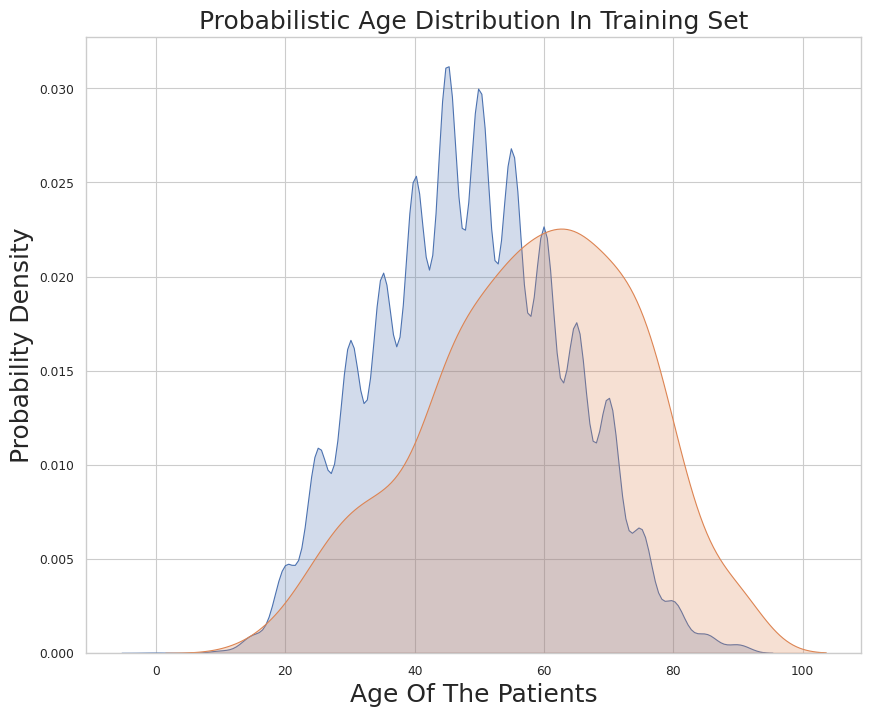

In [ ]:
train_ages_benign = train.loc[train["target"] == 0, "age_approx"]
train_ages_malignant = train.loc[train["target"] == 1 , "age_approx"]

plt.figure(figsize = (10, 8))
sns.kdeplot(train_ages_benign, label = "Benign", shade = True, legend = True, cbar = True)
sns.kdeplot(train_ages_malignant, label = "Malignant", shade = True, legend = True, cbar = True)
plt.grid(True)
plt.xlabel("Age Of The Patients", fontsize = 18)
plt.ylabel("Probability Density", fontsize = 18)
plt.grid(which = "minor", axis = "both")
plt.title("Probabilistic Age Distribution In Training Set", fontsize = 18)

# Getting Insights Into Images :

Using the external dataset compiled in my previous notebook; we will explore various attributes related to our images in the training as well as test set.

*The dataset can be accessed at : /melanoma-image-insights*

In [ ]:
train_image_stats_01 = pd.DataFrame(pd.read_csv("/content/drive/MyDrive/DJANGO/alalade/melanoma-image-insights/melanoma_image_statistics_compiled_01"))
train_image_stats_02 = pd.DataFrame(pd.read_csv("/content/drive/MyDrive/DJANGO/alalade/melanoma-image-insights/melanoma_image_statistics_compiled_02"))
train_image_stats_03 = pd.DataFrame(pd.read_csv("/content/drive/MyDrive/DJANGO/alalade/melanoma-image-insights/melanoma_image_statistics_compiled_03"))
train_image_stats_04 = pd.DataFrame(pd.read_csv("/content/drive/MyDrive/DJANGO/alalade/melanoma-image-insights/melanoma_image_statistics_compiled_04"))
train_image_stats_05 = pd.DataFrame(pd.read_csv("/content/drive/MyDrive/DJANGO/alalade/melanoma-image-insights/melanoma_image_statistics_compiled_05"))
train_image_stats_06 = pd.DataFrame(pd.read_csv("/content/drive/MyDrive/DJANGO/alalade/melanoma-image-insights/melanoma_image_statistics_compiled_06"))

print(train_image_stats_01.shape)
print(train_image_stats_02.shape)
print(train_image_stats_03.shape)
print(train_image_stats_04.shape)
print(train_image_stats_05.shape)
print(train_image_stats_06.shape)

(5000, 11)
(5000, 11)
(5000, 11)
(5000, 11)
(5000, 11)
(8126, 11)


Combining all the pieces in one dataframe.

In [ ]:
train_image_statistics = pd.concat([train_image_stats_01, train_image_stats_02, train_image_stats_03,
                                   train_image_stats_04, train_image_stats_05, train_image_stats_06],
                                  ignore_index = True)
train_image_statistics.shape

(33126, 11)

In [ ]:
train_image_statistics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   image_name                33126 non-null  object 
 1   path                      33126 non-null  object 
 2   rows                      33126 non-null  int64  
 3   columns                   33126 non-null  int64  
 4   channels                  33126 non-null  int64  
 5   image_mean                33126 non-null  float64
 6   image_standard_deviation  33126 non-null  float64
 7   image_skewness            33126 non-null  float64
 8   mean_red_value            33126 non-null  float64
 9   mean_green_value          33126 non-null  float64
 10  mean_blue_value           33126 non-null  float64
dtypes: float64(6), int64(3), object(2)
memory usage: 2.8+ MB


Similarily, working for the test dataframe.

In [ ]:
test_image_stats_01 = pd.DataFrame(pd.read_csv("/content/drive/MyDrive/DJANGO/alalade/melanoma-image-insights/melanoma_image_statistics_compiled_test_01"))
test_image_stats_02 = pd.DataFrame(pd.read_csv("/content/drive/MyDrive/DJANGO/alalade/melanoma-image-insights/melanoma_image_statistics_compiled_test_02"))

print(test_image_stats_01.shape)
print(test_image_stats_02.shape)

(5000, 11)
(5982, 11)


In [ ]:
test_image_statistics = pd.concat([test_image_stats_01, test_image_stats_02], ignore_index = True)

test_image_statistics.shape

(10982, 11)

In [ ]:
test_image_statistics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10982 entries, 0 to 10981
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   image_name                10982 non-null  object 
 1   path                      10982 non-null  object 
 2   rows                      10982 non-null  int64  
 3   columns                   10982 non-null  int64  
 4   channels                  10982 non-null  int64  
 5   image_mean                10982 non-null  float64
 6   image_standard_deviation  10982 non-null  float64
 7   image_skewness            10982 non-null  float64
 8   mean_red_value            10982 non-null  float64
 9   mean_green_value          10982 non-null  float64
 10  mean_blue_value           10982 non-null  float64
dtypes: float64(6), int64(3), object(2)
memory usage: 943.9+ KB


## Let The Image Analysis Begin!!

We generate 4 random samples from the training data set. These 4 samples are taken from the aforementioned array of names.

In [ ]:
random_images = ['ISIC_0083035.jpg',
  'ISIC_0074311.jpg',
  'ISIC_0015719.jpg',
  'ISIC_0077735.jpg'
  ]
random_images

['ISIC_0083035.jpg',
 'ISIC_0074311.jpg',
 'ISIC_0015719.jpg',
 'ISIC_0077735.jpg']

## Sample Images

Earlier we extracted paths of all directories. So, we will access these images from there.

In [ ]:
train_dir = "/content/drive/MyDrive/DJANGO/alalade/siim-isic-melanoma-classification/benign"

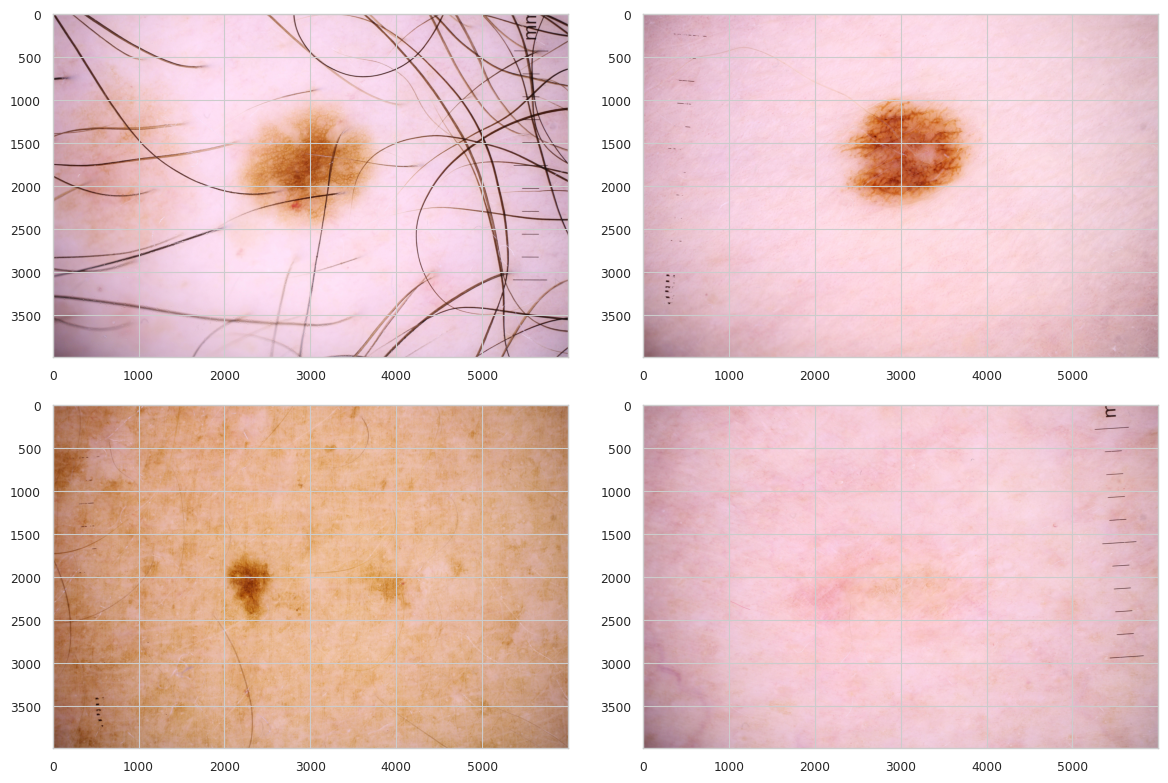

In [ ]:
plt.figure(figsize = (12, 8))
for i in range(4) :
    plt.subplot(2, 2, i + 1)
    image = cv2.imread(os.path.join(train_dir, random_images[i]))
    # cv2 reads images in BGR format. Hence we convert it to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image, cmap = "gray")
    plt.grid(True)
# Automatically adjust subplot parameters to give specified padding.
plt.tight_layout()

# Analysis of color distribution

In [ ]:
benign_mean_red_value = []
benign_mean_green_value = []
benign_mean_blue_value = []

malignant_mean_red_value = []
malignant_mean_green_value = []
malignant_mean_blue_value = []

for image_name in tqdm(train_image_statistics["image_name"]) :
    name = image_name[0:len(image_name)-4] # as .jpg are the appended at the end of the name
    extracted_section = train[train["image_name"] == name]
    r = int(train_image_statistics[train_image_statistics["image_name"] == image_name]["mean_red_value"])
    g = int(train_image_statistics[train_image_statistics["image_name"] == image_name]["mean_green_value"])
    b = int(train_image_statistics[train_image_statistics["image_name"] == image_name]["mean_blue_value"])
    if int(extracted_section["target"]) == 0 : # benign
        benign_mean_red_value.append(r)
        benign_mean_green_value.append(g)
        benign_mean_blue_value.append(b)
    else:
        malignant_mean_red_value.append(r)
        malignant_mean_green_value.append(g)
        malignant_mean_blue_value.append(b)

<ipython-input-54-a1d4218de219>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for image_name in tqdm(train_image_statistics["image_name"]) :


  0%|          | 0/33126 [00:00<?, ?it/s]

<ipython-input-54-a1d4218de219>:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  r = int(train_image_statistics[train_image_statistics["image_name"] == image_name]["mean_red_value"])
<ipython-input-54-a1d4218de219>:13: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  g = int(train_image_statistics[train_image_statistics["image_name"] == image_name]["mean_green_value"])
<ipython-input-54-a1d4218de219>:14: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  b = int(train_image_statistics[train_image_statistics["image_name"] == image_name]["mean_blue_value"])
<ipython-input-54-a1d4218de219>:15: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.il

### Skewness in EDA :

Skewness is the measure of symmetry or asymmetry of a data distribution.
A distribution or data set is said to be symmetric if it looks same to the left and right point of the center.

#### `Types of Skewness` :

Skewness is generally classified into 2 broad categories-
* Right skewness or Positive skewness
* Left skewness or Negative skewness

### Kurtosis :

Kurtosis is the characteristics of being flat or peaked. It is a measure whether data is heavy- tailed or light-tailed in a normal distribution

A large kurtosis value often mean that the tails of the distributions are getting toward more extreme values than the tails of normal distributions. This may lead to a length of 6 or 7 standard deviation from the mean. Similarly, If the kurtosis value is very low, then the tails of the distributions will be less lengthier than the those of a normal distribution (less than 3 standard deviation).

A large value of kurtosis is often considered as more risky because data may tend to give an outlier value as outcome with greater distance from the mean if applied to any machine learning algorithm.

### `Types of Kurtosis` :

It is very difficult to interpret and analyse the data which is skewed.

### `Some Transformations for highly skewed data` :

We can perform a number of transformations so that the data information remains preserved while at the same time some symmetric nature starts developing in its distribution.

* Taking the square root of each data point and plotting it again.
* Taking the cube root of each data point and plotting it again.
* Taking the logarithm of each data point and plotting it again.
* Taking the reciprocal of each data point and plotting it again.

Channel plotting

<ipython-input-55-854e375cc67f>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  fig = sns.distplot(benign_mean_red_value, hist = True, kde = True, label = "Mean Red Channel Intensities", color = "r")


The range of spread = 218.00


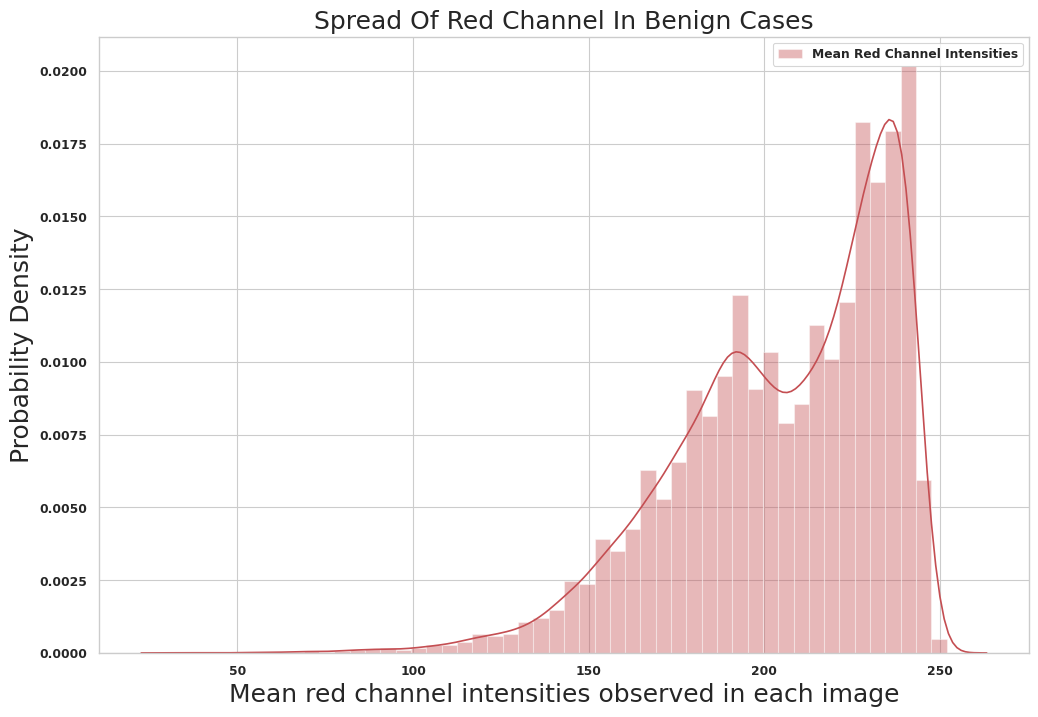

In [ ]:
#red channel plot
range_of_spread = max(benign_mean_red_value) - min(benign_mean_red_value)

plt.figure(figsize = (12, 8))
plt.rc("font", weight = "bold")
sns.set_style("whitegrid")
fig = sns.distplot(benign_mean_red_value, hist = True, kde = True, label = "Mean Red Channel Intensities", color = "r")
fig.set(xlabel = "Mean red channel intensities observed in each image",
        ylabel = "Probability Density")
plt.title("Spread Of Red Channel In Benign Cases", fontsize = 18)
plt.legend()
print("The range of spread = {:.2f}".format(range_of_spread))

<ipython-input-56-0fa1d2f767f9>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  fig = sns.distplot(benign_mean_green_value, hist = True, kde = True, label = "Mean Green Channel Intensities", color = "g")


The range of spread = 236.00


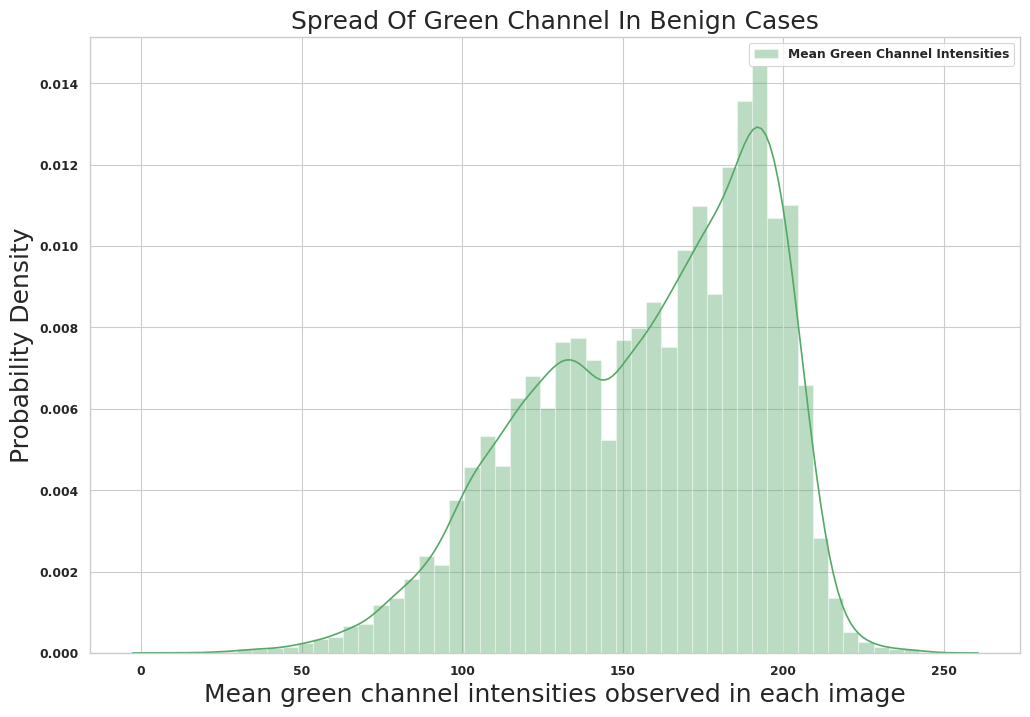

In [ ]:
# green channel plot
range_of_spread = max(benign_mean_green_value) - min(benign_mean_green_value)

plt.figure(figsize = (12, 8))
plt.rc("font", weight = "bold")
sns.set_style("whitegrid")
fig = sns.distplot(benign_mean_green_value, hist = True, kde = True, label = "Mean Green Channel Intensities", color = "g")
fig.set(xlabel = "Mean green channel intensities observed in each image",
        ylabel = "Probability Density")
plt.title("Spread Of Green Channel In Benign Cases", fontsize = 18)
plt.legend()
print("The range of spread = {:.2f}".format(range_of_spread))

<ipython-input-57-fe7f20e0dac1>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  fig = sns.distplot(benign_mean_blue_value, hist = True, kde = True, label = "Mean Blue Channel Intensities", color = "b")


The range of spread = 242.00


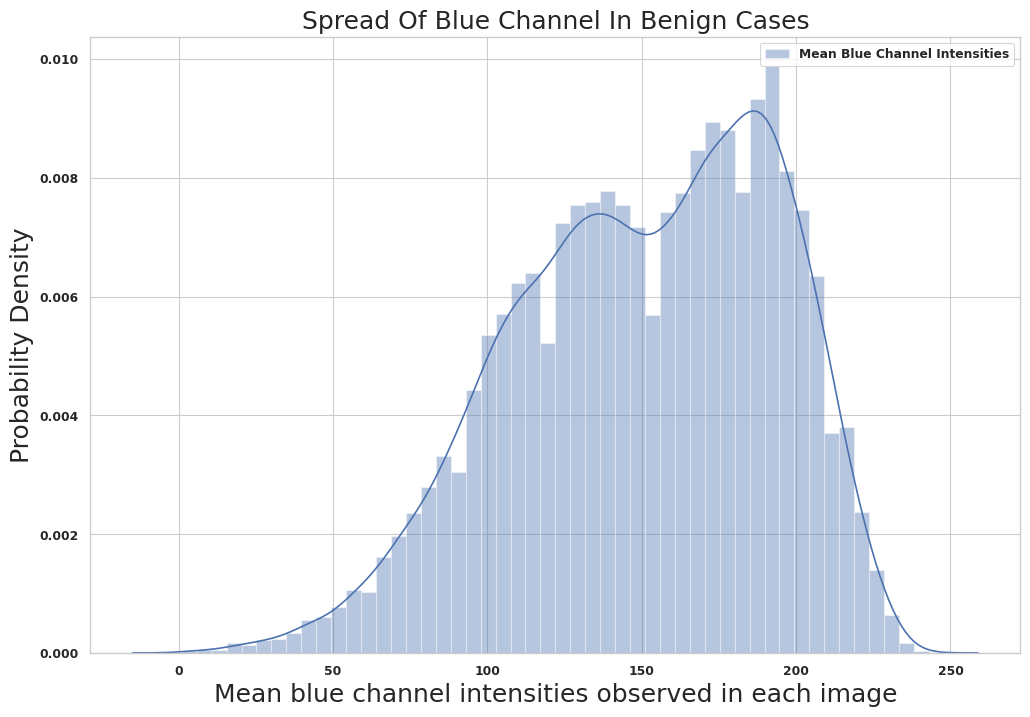

In [ ]:
#Blue channel plot
range_of_spread = max(benign_mean_blue_value) - min(benign_mean_blue_value)

plt.figure(figsize = (12, 8))
plt.rc("font", weight = "bold")
sns.set_style("whitegrid")
fig = sns.distplot(benign_mean_blue_value, hist = True, kde = True, label = "Mean Blue Channel Intensities", color = "b")
fig.set(xlabel = "Mean blue channel intensities observed in each image",
        ylabel = "Probability Density")
plt.title("Spread Of Blue Channel In Benign Cases", fontsize = 18)
plt.legend()
print("The range of spread = {:.2f}".format(range_of_spread))

<ipython-input-58-2a5923e86d57>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  fig = sns.distplot(benign_mean_blue_value, hist = False, kde = True, label = "Mean Blue Channel Intensities", color = "b")
<ipython-input-58-2a5923e86d57>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  fig = sns.distplot(

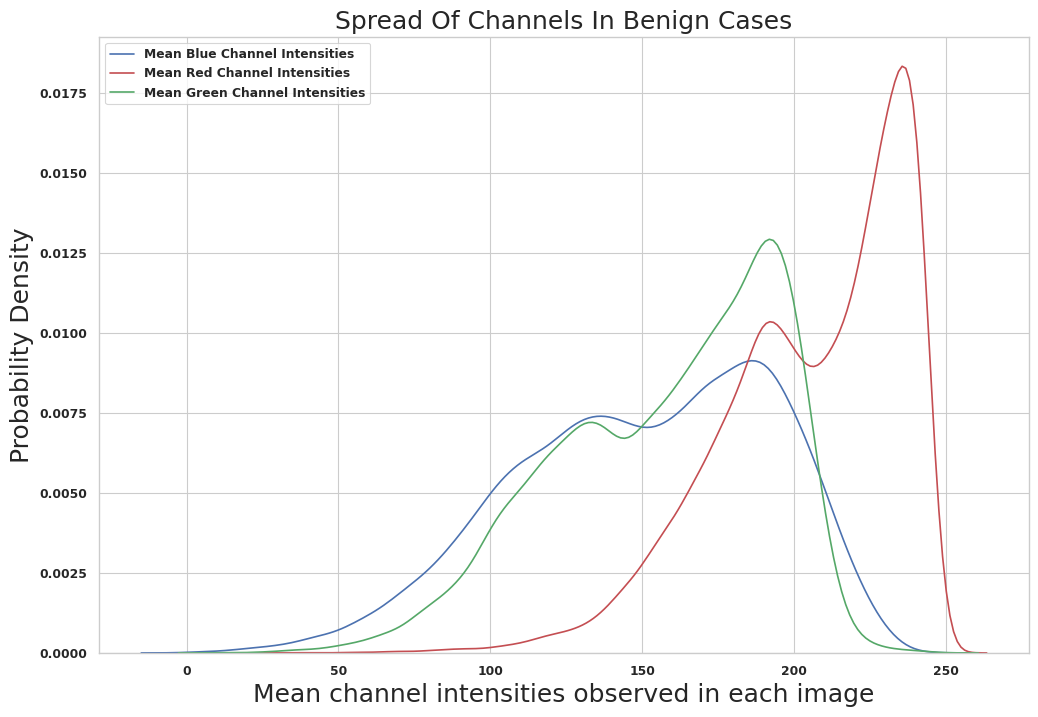

In [ ]:
plt.figure(figsize = (12, 8))
plt.rc("font", weight = "bold")
sns.set_style("whitegrid")
fig = sns.distplot(benign_mean_blue_value, hist = False, kde = True, label = "Mean Blue Channel Intensities", color = "b")
fig = sns.distplot(benign_mean_red_value, hist = False, kde = True, label = "Mean Red Channel Intensities", color = "r")
fig = sns.distplot(benign_mean_green_value, hist = False, kde = True, label = "Mean Green Channel Intensities", color = "g")

fig.set(xlabel = "Mean channel intensities observed in each image",
        ylabel = "Probability Density")
plt.title("Spread Of Channels In Benign Cases", fontsize = 18)
plt.legend()

Melanoma Cases

In [ ]:
# free up the memory
del benign_mean_red_value
del benign_mean_green_value
del benign_mean_blue_value

In [ ]:
gc.collect()

13794

<ipython-input-61-86b90e68ede6>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  fig = sns.distplot(malignant_mean_blue_value, hist = False, kde = True, label = "Mean Blue Channel Intensities", color = "b")
<ipython-input-61-86b90e68ede6>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  fig = sns.distpl

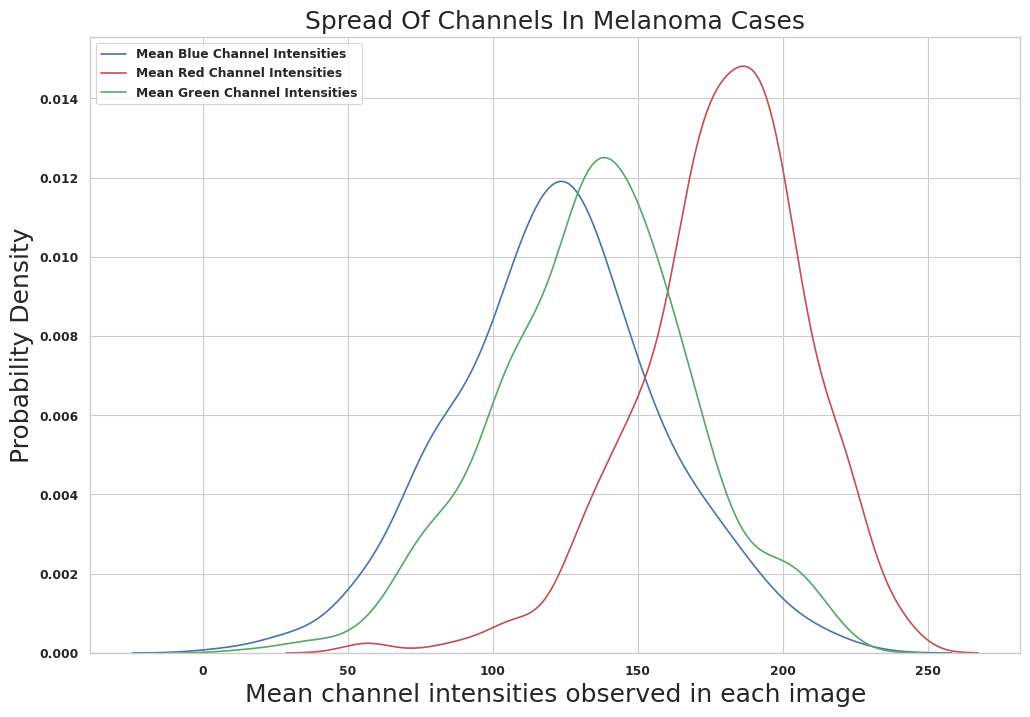

In [ ]:
plt.figure(figsize = (12, 8))
plt.rc("font", weight = "bold")
sns.set_style("whitegrid")
fig = sns.distplot(malignant_mean_blue_value, hist = False, kde = True, label = "Mean Blue Channel Intensities", color = "b")
fig = sns.distplot(malignant_mean_red_value, hist = False, kde = True, label = "Mean Red Channel Intensities", color = "r")
fig = sns.distplot(malignant_mean_green_value, hist = False, kde = True, label = "Mean Green Channel Intensities", color = "g")

fig.set(xlabel = "Mean channel intensities observed in each image",
        ylabel = "Probability Density")
plt.title("Spread Of Channels In Melanoma Cases", fontsize = 18)
plt.legend()

So, we observe that in both the cases the component of red spikes the most, whereas Blue and Green are close to each other. All the channels also appears to be a bit negatively skewed.

`**Hence, the channel distribution won't be a powerful feature to differentiate between the melanoma and benign cases.**`

Kutosis of this distribution is manageable.

In [ ]:
gc.collect() # free up the memory

19542

# Dealing with missing values :

Filling the areas of missing values in the dataframe.

In [ ]:
train.head()

image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_2637011  IP_7279968    male        45.0                     head/neck   
1  ISIC_0015719  IP_3075186  female        45.0               upper extremity   
2  ISIC_0052212  IP_2842074  female        50.0               lower extremity   
3  ISIC_0068279  IP_6890425  female        45.0                     head/neck   
4  ISIC_0074268  IP_8723313  female        55.0               upper extremity   

  diagnosis benign_melanoma  target  
0   unknown          benign       0  
1   unknown          benign       0  
2     nevus          benign       0  
3   unknown          benign       0  
4   unknown          benign       0

Sex feature column

Count of missing data =  65
Count of available data =  33061


Text(0.5, 1.0, "Data On Patient's Sex")

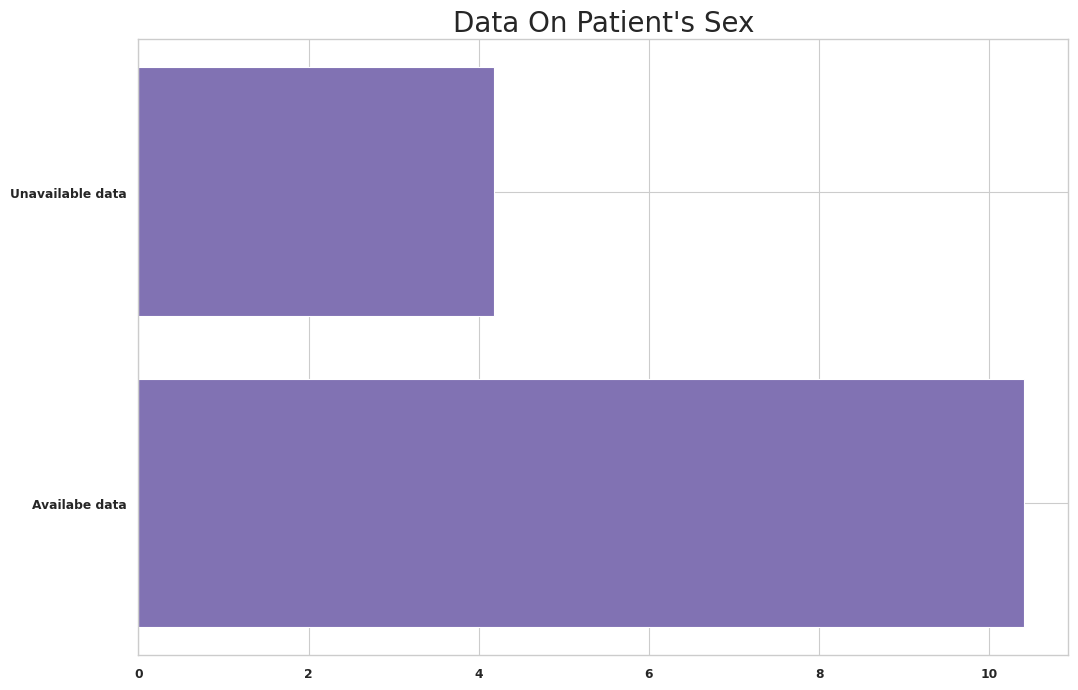

In [ ]:
# visualizing missing values in "sex" column

missing = len(train[train["sex"].isna() == True])
available = len(train[train["sex"].isna() == False])

x = ["Availabe data", "Unavailable data"]
y = [np.log(available), np.log(missing)] # plotting log data as the extreme values will supressed and lower ones will shoot, making it eay to visualize

print("Count of missing data = ", missing)
print("Count of available data = ", available)

plt.figure(figsize = (12, 8))
plt.subplot(1,1,1)
plt.barh(x, y, color = "m")
plt.grid(True)
plt.title("Data On Patient's Sex")

In the starting part of EDA, we saw that the male gender dominated the gender count slightly. So, we fill the missing values with the dominant gender in the dataset.

In [ ]:
train["sex"].fillna("male", inplace = True)

Age feature column

Missing age values =  68
Available age data =  33058


Text(0.5, 1.0, "Data On Patient's Age")

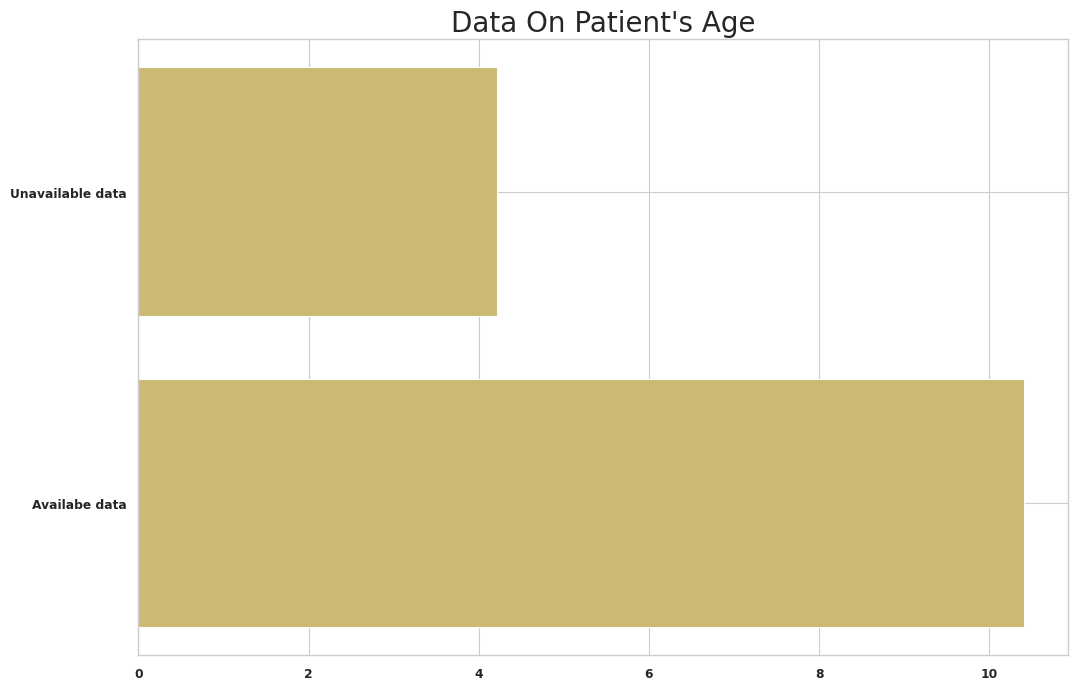

In [ ]:
missing =  len(train[train["age_approx"].isna() == True])
available = len(train[train["age_approx"].isna() == False])

print("Missing age values = ", missing)
print("Available age data = ", available)

x = ["Availabe data", "Unavailable data"]
y = [np.log(available), np.log(missing)] # plotting log data as the extreme values will supressed and lower ones will shoot, making it eay to visualize

plt.figure(figsize = (12, 8))
plt.subplot(1,1,1)
plt.barh(x, y, color = "y")
plt.grid(True)
plt.title("Data On Patient's Age")

This is similar to the sex distribution part.

We know so far

* Males are relatively dominant in count in the dataset
* Torso, lower extremity and upper extremity corresponds to more than 70% of overall locations(initial EDA steps)
* Number of melanoma cases are far less than benign, and then also they male count dominates in both.

Therefore, we fill the missing values with the median data at the union of the aforementioned cases. Let's see how...

In [ ]:
# train
anatomy_sites = ["torso", "upper extremity", "lower extremity"]

# first select the relevant part of the full dataframe satisfying either of the aforementioned three conditions.
relevant_dataframe_part = train[(train["sex"] == "male") &
                     (train["anatom_site_general_challenge"].isin(anatomy_sites)) &
                     (train["target"] == 0)]

# Now, we have the data frame. To calculate median, we need to specify the column along which we intend to calculate the median.
median_value = relevant_dataframe_part["age_approx"].median()

print("Median value = ", median_value)

Median value =  50.0


In [ ]:
train["age_approx"].fillna(median_value, inplace = True)

Anatomy feature column

We simply replace the missing values(if any) with "TORSO" class, as it is the dominant one here.

In [ ]:
train["anatom_site_general_challenge"].fillna("torso", inplace = True)
test["anatom_site_general_challenge"].fillna("torso", inplace = True)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33126 non-null  object 
 3   age_approx                     33126 non-null  float64
 4   anatom_site_general_challenge  33126 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_melanoma                33126 non-null  object 
 7   target                         33126 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 2.0+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10982 entries, 0 to 10981
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     10982 non-null  object 
 1   patient_id                     10982 non-null  object 
 2   sex                            10982 non-null  object 
 3   age_approx                     10982 non-null  float64
 4   anatom_site_general_challenge  10982 non-null  object 
dtypes: float64(1), object(4)
memory usage: 429.1+ KB


So, now we have dealt with missing values!!! :-)

Save these so that we can use these updated CSV files in the next notebook where we tackle preprocessing and model creation.

In [ ]:
train.to_csv("updated_training_file.csv", index = False)
test.to_csv("updated_test_file.csv", index = False)

## Gaining more insights from the images :

Let's analyze the information presented by the *melanoma-image-insights* dataset.

Shape related information :

<ipython-input-73-4edc9efea8ce>:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, cmap = "magma")
<ipython-input-73-4edc9efea8ce>:14: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, cmap = "magma")


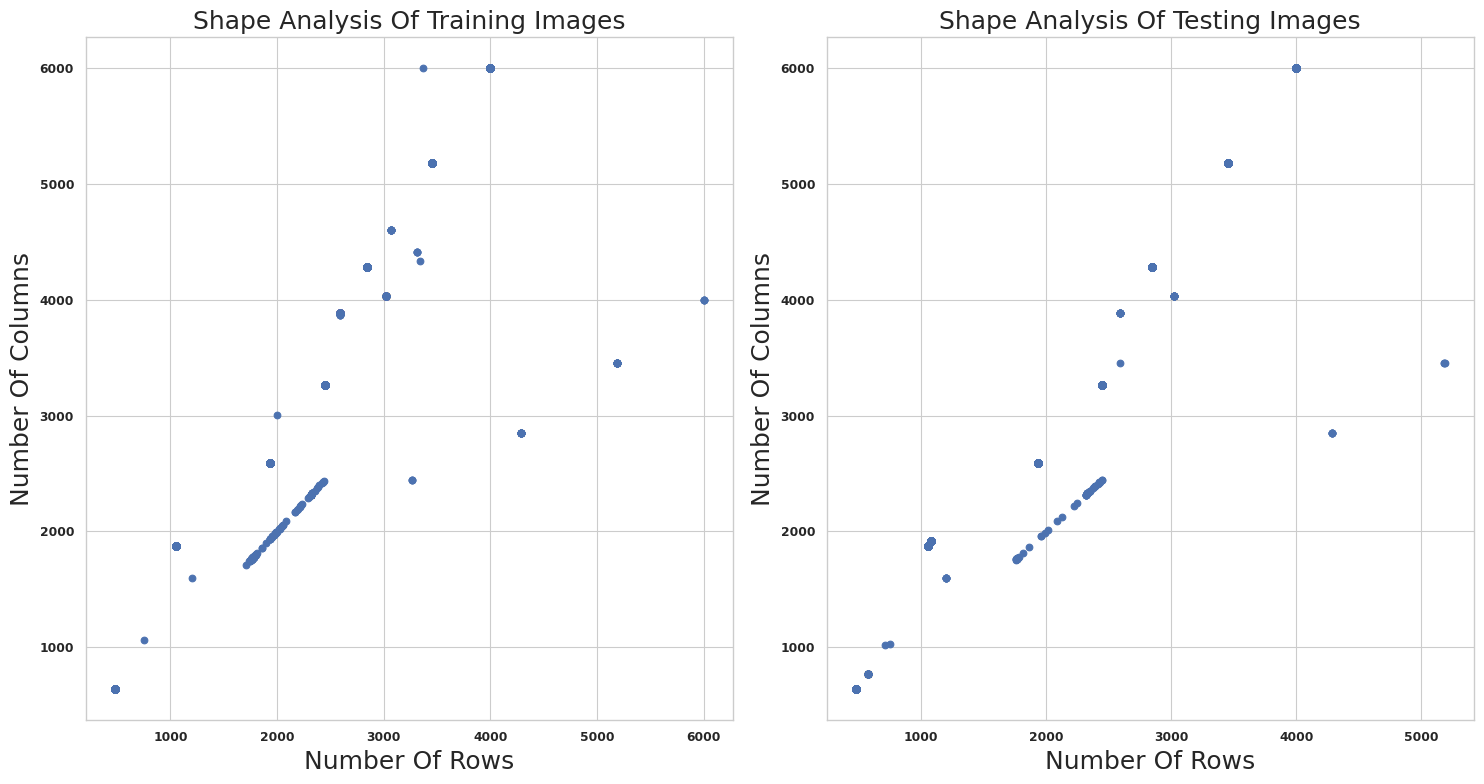

In [ ]:
plt.figure(figsize = (15, 8))

plt.subplot(1,2,1)
x = train_image_statistics["rows"]
y = train_image_statistics["columns"]
plt.scatter(x, y, cmap = "magma")
plt.title("Shape Analysis Of Training Images", fontsize = 18)
plt.xlabel("Number Of Rows", fontsize = 18)
plt.ylabel("Number Of Columns", fontsize = 18)

plt.subplot(1,2,2)
x = test_image_statistics["rows"]
y = test_image_statistics["columns"]
plt.scatter(x, y, cmap = "magma")
plt.title("Shape Analysis Of Testing Images", fontsize = 18)
plt.xlabel("Number Of Rows", fontsize = 18)
plt.ylabel("Number Of Columns", fontsize = 18)


plt.tight_layout()

It's a tad difficult to analyze like this! Therefore we'll plot them in one.

<ipython-input-74-7aaa1f3b8e33>:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, cmap = "plasma", label = "Training Image")
<ipython-input-74-7aaa1f3b8e33>:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, cmap = "magma", label = "Testing Image")


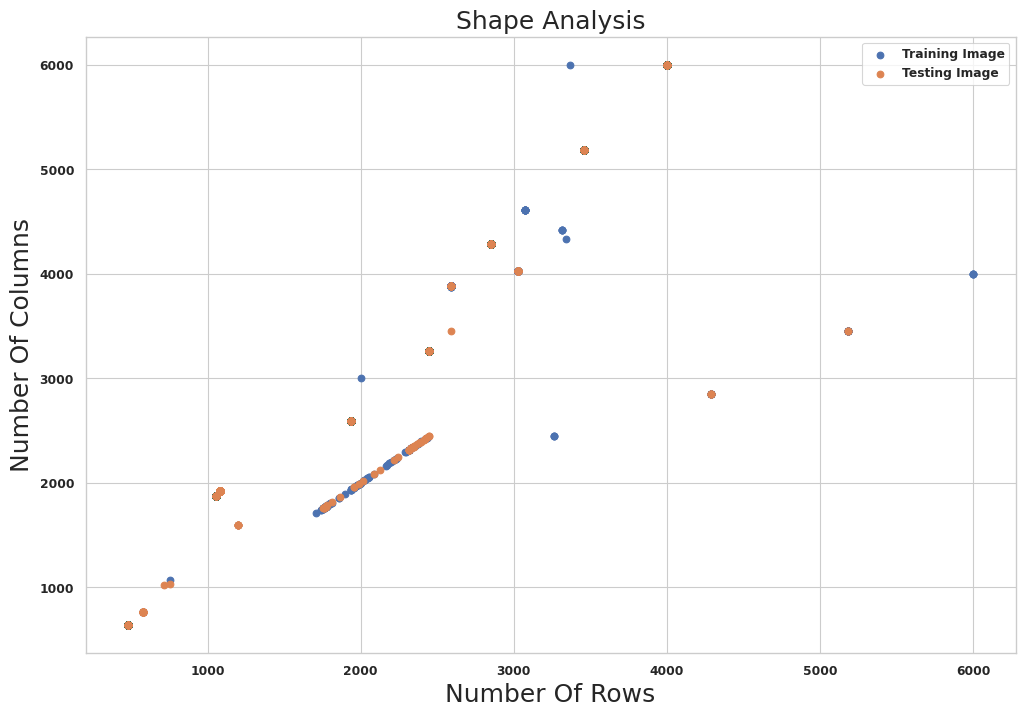

In [ ]:
plt.figure(figsize = (12, 8))

x = train_image_statistics["rows"]
y = train_image_statistics["columns"]
plt.scatter(x, y, cmap = "plasma", label = "Training Image")
plt.title("Shape Analysis", fontsize = 18)

x = test_image_statistics["rows"]
y = test_image_statistics["columns"]
plt.scatter(x, y, cmap = "magma", label = "Testing Image")

plt.xlabel("Number Of Rows", fontsize = 18)
plt.ylabel("Number Of Columns", fontsize = 18)
plt.legend()

We observe that most common dimension in training and testing set's intersection is 1800 X 1800 to 2500 X 2500. We will reshape the images accordingly later in the preprocessing segment.

Let's analyze Image mean, standard deviation and skewness with one another. For this we will use plotly's express. Plotly Express is the easy-to-use, high-level interface to Plotly, which operates on a variety of types of data and produces easy-to-style figures.

mpltoolkit can also be used if you are adamant using matplotlib.

In [ ]:
fig = go.Figure(data = [go.Scatter3d(x = train_image_statistics["image_mean"],
                                    y = train_image_statistics["image_standard_deviation"],
                                   z = train_image_statistics["image_skewness"],
                                    mode = "markers",
                                    marker = dict(size = 4, color = train_image_statistics["rows"],

                                                  colorscale = "jet", opacity = 0.4))] ,

                layout = go.Layout(margin=dict(l=0, r=0, b=0, t=0),
                                   scene = dict(xaxis = dict(title='Image Mean'),
                                                yaxis = dict(title='Image Standard Deviation'),
                                                zaxis = dict(title='Image Skewness'),),))
fig.show()

Repeating for the test data :

In [ ]:
fig = go.Figure(data = [go.Scatter3d(x = test_image_statistics["image_mean"],
                                    y = test_image_statistics["image_standard_deviation"],
                                   z = test_image_statistics["image_skewness"],
                                    mode = "markers",
                                    marker = dict(size = 4, color = test_image_statistics["rows"],

                                                  colorscale = "jet", opacity = 0.4))] ,

                layout = go.Layout(margin=dict(l=0, r=0, b=0, t=0),
                                   scene = dict(xaxis = dict(title='Image Mean'),
                                                yaxis = dict(title='Image Standard Deviation'),
                                                zaxis = dict(title='Image Skewness'),),))

fig.show()

## Melanoma EDA

In [ ]:
def pick_random_images(folder_path, num_images=5):
    # List all files in the folder
    files = os.listdir(folder_path)

    # Filter out only image files (e.g., .jpg, .png, etc.)
    image_extensions = ('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')
    image_files = [file for file in files if file.lower().endswith(image_extensions)]

    # Pick random image files from the list
    if len(image_files) < num_images:
        num_images = len(image_files)

    random_images = random.sample(image_files, num_images)
    return random_images


In [ ]:
def image_statistics(image):
    # Calculate statistics
    mean = np.mean(image, axis=(0, 1))
    std_dev = np.std(image, axis=(0, 1))
    return mean, std_dev

In [ ]:
def display_images(folder_path, image_names):
    plt.figure(figsize=(20, 20))
    for i, image_name in enumerate(image_names):
        image_path = os.path.join(folder_path, image_name)
        image = cv2.imread(image_path)

        if image is not None:
            # Convert image from BGR to RGB
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Get image statistics
            mean, std_dev = image_statistics(image_rgb)

            # Grayscale image
            gray_image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)

            # Edge detection using Canny
            edges = cv2.Canny(gray_image, 100, 200)

            # Plot original image
            plt.subplot(len(image_names), 4, i*4+1)
            plt.imshow(image_rgb)
            plt.title(f"Image: {image_name}\nMean: {mean}\nStd Dev: {std_dev}")
            plt.axis('off')

            # Plot grayscale image
            plt.subplot(len(image_names), 4, i*4+2)
            plt.imshow(gray_image, cmap='gray')
            plt.title("Grayscale Image")
            plt.axis('off')

            # Plot edges
            plt.subplot(len(image_names), 4, i*4+3)
            plt.imshow(edges, cmap='gray')
            plt.title("Edges")
            plt.axis('off')

            # Plot histogram for RGB channels
            plt.subplot(len(image_names), 4, i*4+4)
            colors = ('r', 'g', 'b')
            for j, color in enumerate(colors):
                hist = cv2.calcHist([image_rgb], [j], None, [256], [0, 256])
                plt.plot(hist, color=color)
            plt.title("Histogram")
            plt.xlim([0, 256])
        else:
            print(f"Error: Unable to read the image file {image_name}.")
    plt.tight_layout()
    plt.show()

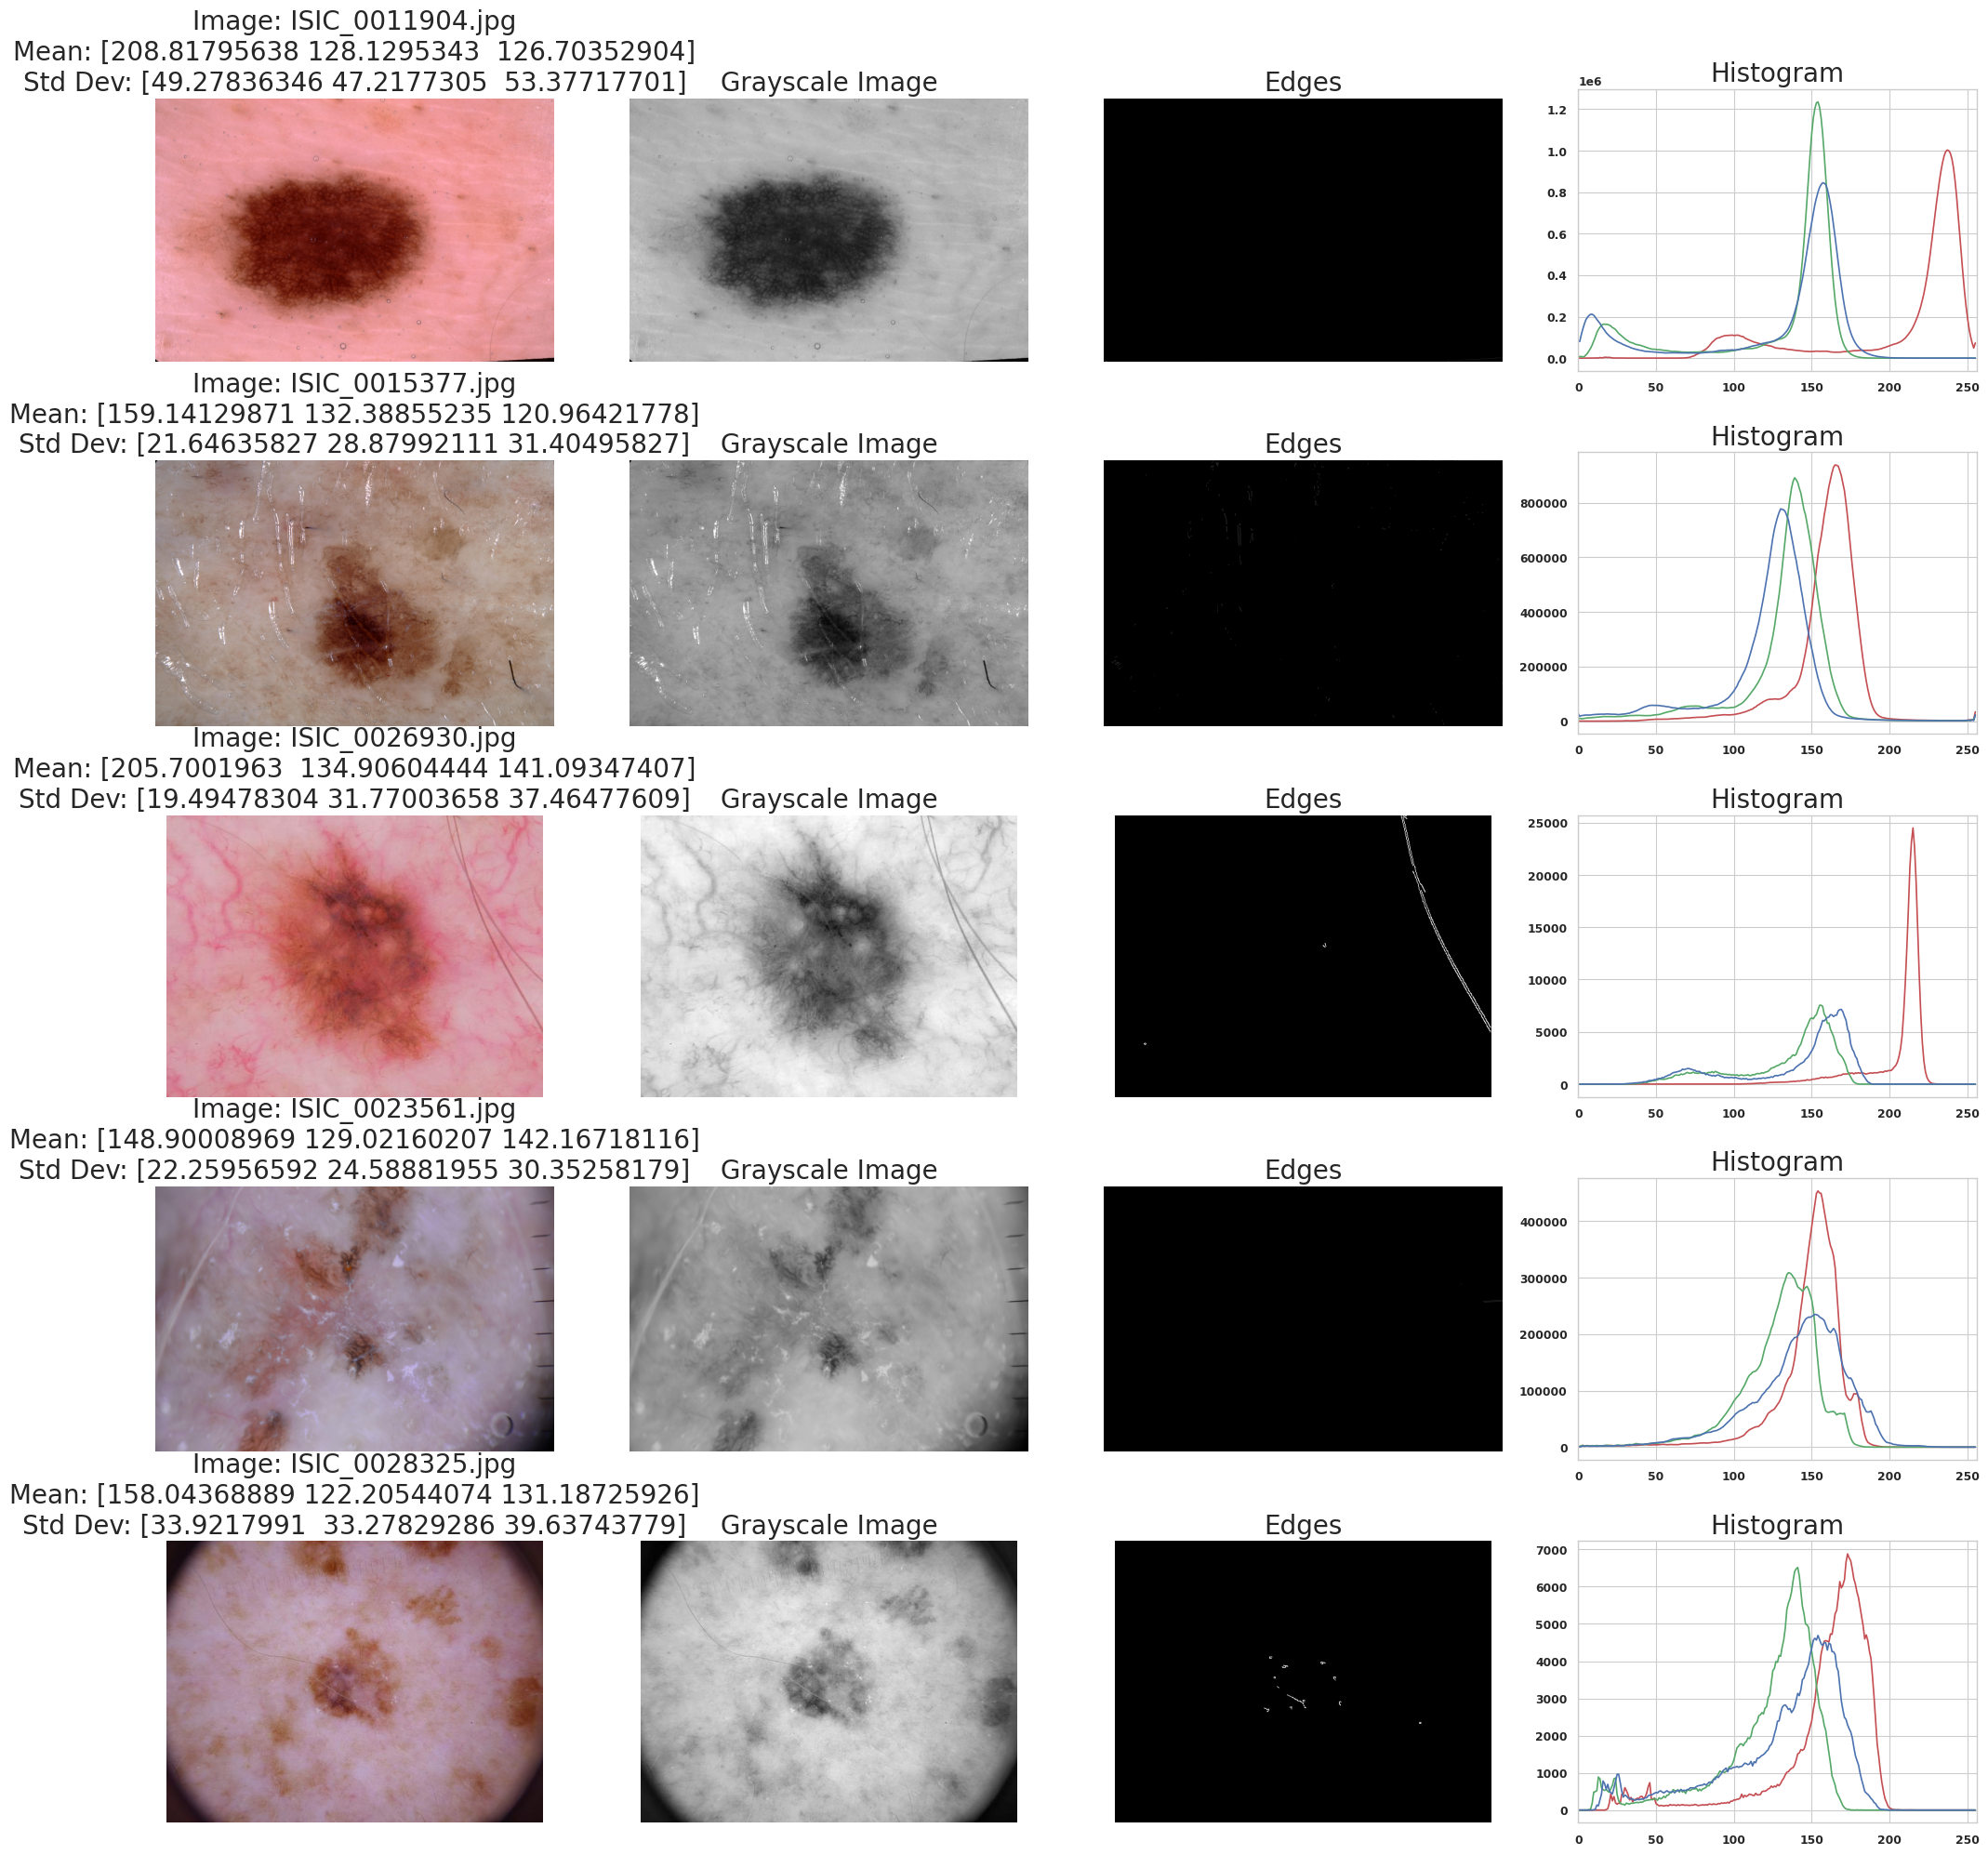

In [ ]:
# Example usage
folder_path = '/content/drive/MyDrive/DJANGO/alalade/siim-isic-melanoma-classification/melanoma'
random_images = pick_random_images(folder_path, num_images=5)
display_images(folder_path, random_images)

### Interpretation of the Results

When analyzing and visualizing the images, several key insights can be drawn from the Extended Exploratory Data Analysis (EDA) performed:

#### 1. **Original Image**
   This gives a direct visual representation of the skin lesion, which helps in understanding the general appearance, texture, and color distribution of the lesion. Visual inspection can provide initial insights into the presence of melanoma, but further quantitative analysis is necessary for accurate diagnosis.

#### 2. **Grayscale Image**
   Grayscale images highlight the intensity of light in the image, removing the color information. This can be useful for detecting features and patterns that are not as obvious in the colored image. Dermatologists and computer algorithms can use these patterns to identify abnormalities.

#### 3. **Edge Detection (Canny Edge Detection)**
   Edge detection helps in identifying the boundaries and shapes within the image. In the context of melanoma detection, edge detection can be useful for delineating the borders of the lesion. Irregular or blurry edges can be indicative of melanoma melanoma, whereas benign lesions tend to have smooth, well-defined edges.

#### 4. **Histogram for RGB Channels**
  - **Color Distribution**: The histogram provides a quantitative representation of the color distribution in the image. Peaks and valleys in the histogram indicate the prevalence of certain color intensities.
  - **Lesion Analysis**: The color distribution can help in differentiating between benign and melanoma lesions. For instance, melanomas might exhibit irregular color patterns and a broader range of color intensities compared to benign lesions.
  - **Mean and Standard Deviation**: The mean and standard deviation for each channel give an overall sense of the color intensity and variation. Higher variation might suggest a more heterogeneous lesion, which can be a characteristic of melanoma.

### Summary of Findings
From the extended EDA of the melanoma images, the following observations can be made:
- **Visual Inspection**: The original and grayscale images provide an initial visual assessment of the lesion, which can be used for manual or automated inspection.
- **Boundary Detection**: Edge detection highlights the lesion's boundaries, which can help in assessing its shape and border regularity.
- **Color Analysis**: The RGB histograms offer a detailed look at the color properties of the lesion, which is useful for further quantitative analysis.




### Insights
The insights gained from this EDA are crucial for feature engineering and model development:
- **Grayscale and Edge Features**: The grayscale and edge-detected images can be used to extract features related to texture, shape, and intensity, which are important for classification models.
- **Color Features**: The RGB histograms can be used to derive color-based features that help in differentiating between benign and melanoma lesions.

Overall, the extended EDA provides a comprehensive understanding of the melanoma images, laying a strong foundation for further machine learning analysis and model development.

In [ ]:
train.head()

image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_2637011  IP_7279968    male        45.0                     head/neck   
1  ISIC_0015719  IP_3075186  female        45.0               upper extremity   
2  ISIC_0052212  IP_2842074  female        50.0               lower extremity   
3  ISIC_0068279  IP_6890425  female        45.0                     head/neck   
4  ISIC_0074268  IP_8723313  female        55.0               upper extremity   

  diagnosis benign_melanoma  target  
0   unknown          benign       0  
1   unknown          benign       0  
2     nevus          benign       0  
3   unknown          benign       0  
4   unknown          benign       0

In [ ]:
process_df = train[train["benign_melanoma"] == "benign"]
process_df.head()

image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_2637011  IP_7279968    male        45.0                     head/neck   
1  ISIC_0015719  IP_3075186  female        45.0               upper extremity   
2  ISIC_0052212  IP_2842074  female        50.0               lower extremity   
3  ISIC_0068279  IP_6890425  female        45.0                     head/neck   
4  ISIC_0074268  IP_8723313  female        55.0               upper extremity   

  diagnosis benign_melanoma  target  
0   unknown          benign       0  
1   unknown          benign       0  
2     nevus          benign       0  
3   unknown          benign       0  
4   unknown          benign       0

In [ ]:
process_df["image_name"]

0        ISIC_2637011
1        ISIC_0015719
2        ISIC_0052212
3        ISIC_0068279
4        ISIC_0074268
             ...     
33121    ISIC_9999134
33122    ISIC_9999320
33123    ISIC_9999515
33124    ISIC_9999666
33125    ISIC_9999806
Name: image_name, Length: 32542, dtype: object

The essence of this preprocesing is to

In [ ]:
import os
import pandas as pd
import shutil

def fetch_and_copy_images(df, image_name_field, source_folder, destination_folder):
    """
    Fetch images based on a DataFrame field and copy them to a new folder.

    Parameters:
    df (pd.DataFrame): DataFrame containing image names.
    image_name_field (str): Column name in the DataFrame that contains the image names.
    source_folder (str): Folder path where the images are currently located.
    destination_folder (str): Folder path where the images should be copied to.
    """
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    for image_name in df[image_name_field]:
        source_path = os.path.join(source_folder, image_name)
        if os.path.exists(source_path):
            shutil.copy(source_path, destination_folder)
            print(f"Copied {image_name} to {destination_folder}")
        else:
            print(f"{image_name} does not exist in the source folder.")

# Example usage
# Create a sample DataFrame
data = {'image_name': ['image1.jpg', 'image2.jpg', 'image3.jpg']}
df = process_df

# Define source and destination folders
source_folder = '/content/drive/MyDrive/DJANGO/alalade/siim-isic-melanoma-classification/jpeg/train'
destination_folder = '/content/drive/MyDrive/DJANGO/alalade/siim-isic-melanoma-classification/benign'

# Call the function
fetch_and_copy_images(df, "image_name", source_folder, destination_folder)


Streaming output truncated to the last 5000 lines.
ISIC_8488057 does not exist in the source folder.
ISIC_8488204 does not exist in the source folder.
ISIC_8488336 does not exist in the source folder.
ISIC_8489863 does not exist in the source folder.
ISIC_8490373 does not exist in the source folder.
ISIC_8490701 does not exist in the source folder.
ISIC_8490884 does not exist in the source folder.
ISIC_8491192 does not exist in the source folder.
ISIC_8491294 does not exist in the source folder.
ISIC_8492070 does not exist in the source folder.
ISIC_8492249 does not exist in the source folder.
ISIC_8492388 does not exist in the source folder.
ISIC_8492463 does not exist in the source folder.
ISIC_8492638 does not exist in the source folder.
ISIC_8492731 does not exist in the source folder.
ISIC_8492829 does not exist in the source folder.
ISIC_8492957 does not exist in the source folder.
ISIC_8493313 does not exist in the source folder.
ISIC_8493401 does not exist in the source folder.